# Fine-tune Llama3.2 11B/90B vision models on ChartQA with synthetic reasoning to boost accuracy

This tutorial demonstrates how to use Torchtune to fine-tune Llama3.2 11B/90B multi-modal models on the ChartQA dataset using a single AMD Instinct MI300X GPU. To boost the inference accuracy of the model we create a synthetic dataset to add a chain of thought (COT) to the ChartQA samples training the model to first reason about their answer. 

Torchtune is an easy-to-use PyTorch library for authoring, post-training, and experimenting with LLMs. It features:

- Hackable training recipes for SFT, knowledge distillation, RL and RLHF, and quantization-aware training.
- Simple PyTorch implementations of popular LLMs like Llama, Gemma, Mistral, Phi, Qwen, and more.
- OOTB best-in-class memory efficiency, performance improvements, and scaling, utilizing the latest PyTorch APIs.
- YAML configs to easily configure training, evaluation, quantization, or inference recipes.

For more information, see the [official torchtune GitHub page](https://github.com/pytorch/torchtune).

## Prerequisites

This tutorial was developed and tested using the following setup. 

### Operating system

* **Ubuntu 22.04**: Ensure your system is running Ubuntu version 22.04.

### Hardware

* **AMD Instinct™ GPUs**: This tutorial was designed and tested on a single AMD Instinct MI300X GPU. Ensure you are using an AMD Instinct GPU or compatible hardware with ROCm support and that your system meets the [official requirements](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/reference/system-requirements.html).

### Software

* **ROCm 6.3**: Install and verify ROCm by following the [ROCm install guide](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/install/quick-start.html). After installation, confirm your setup using:

    ``` bash
    rocm-smi
    ```

    This command lists your AMD GPUs with relevant details, similar to the image below.

   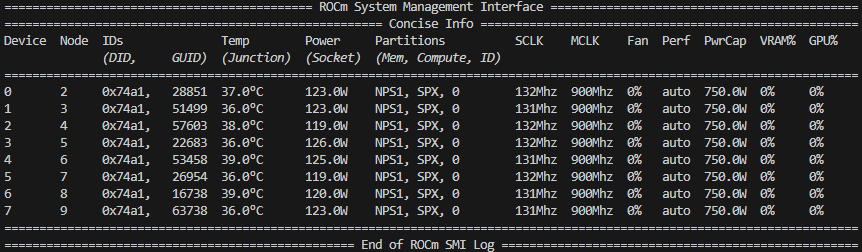

### Hugging Face API access

* Note that we have already obtain an API token into the image from [Hugging Face](https://huggingface.co) for downloading relevant models.



## Prepare the training environment

Next we need to prepare the training environment. We will be installing the dependency base on a pre-built docker image. There is a jupyter notebook server installed in the image which we can connect and then continue the setup from within this notebook. If you have not found any message, please refer to [guide](https://github.com/seungrokj/AAI25_workshop/blob/main/ws_102_Finetuning_AI_Models/README.md)


### 0. Verify torchtune for ROCm 6.3

To confirm that the package is installed correctly, run the following command:

In [ ]:
# Verify the installation and version of the required libraries
!pip list | grep torch

Here is the expected output:

```
Using Python 3.12.3 environment at: /root/venv
pytorch-triton-rocm       3.3.1
torch                     2.7.1+rocm6.3
torchao                   0.11.0+gitf34b473
torchaudio                2.7.1+rocm6.3
torchdata                 0.11.0
torchtune                 0.0.0
torchvision               0.22.1+rocm6.3
```

In [ ]:
!tune --help

You should see the following output:

```
usage: tune [-h] {download,ls,cp,run,validate,cat} ...

Welcome to the torchtune CLI!

options:
  -h, --help            show this help message and exit

subcommands:
  {download,ls,cp,run,validate,cat}
    download            Download a model from the Hugging Face Hub or Kaggle
                        Model Hub.
    ls                  List all built-in recipes and configs
    cp                  Copy a built-in recipe or config to a local path.
    run                 Run a recipe. For distributed recipes, this supports
                        all torchrun arguments.
    validate            Validate a config and ensure that it is well-formed.
    cat                 Pretty print a config, making it easy to know which
                        parameters you can override with `tune run`.
```

### 1. (Optional) Install the required libraries

If user observe issue at step 0, then install the libraries required for this tutorial. Run the following commands inside the Jupyter notebook running within the Docker container:

In [ ]:
# Skip installing Torch and related packages if they are already installed.
# Install torchtune, torchvision, torchao nightlies
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/rocm6.3
#!pip install -U git+https://github.com/pytorch/torchtune@20bdf10
#!pip install git+https://github.com/pytorch/ao@v0.11.0 --no-build-isolation

### 2. Verify that huggingface token is working correctly:

To confirm that user are authorized to download llama model correctly, run the following command:

In [ ]:
from huggingface_hub import HfApi

try:
    api = HfApi()
    user_info = api.whoami()
    print(f"Token validated successfully! Logged in as: {user_info['name']}")
except Exception as e:
    print(f"Token validation failed. Error: {e}")

In [ ]:
from huggingface_hub import notebook_login, HfApi

# Prompt the user to log in
notebook_login()


**⚠️ Important: ensure the correct kernel is selected**

If the verification process fails, ensure the correct Jupyter kernel is selected for your notebook.
To change the kernel, follow these steps:

1. Go to the **Kernel** menu.
2. Select **Change Kernel**.
3. Select `Python 3 (ipykernel)` from the list.

**Important**: Failure to select the correct kernel can lead to unexpected issues when running the notebook.


## Data preparation

* This tutorial creates a synthetic dataset derived from the ChartQA training split to add a CoT to each sample. The repo provides the reasoning portion of the new dataset for which we leveraged a Llama 3.2 90B vision model to create a chain of thought (CoT) leading to the original answer of ChartQA. The CoT will help the model to reach at the final correct solution. We provide a script to merge the original ChartQA data with the reasoning part:

In [ ]:
from utils import create_chart_qa_with_reasoning_dataset
create_chart_qa_with_reasoning_dataset('reasoning.parquet', 'cot_chartqa', override=False)

In [ ]:
from datasets import load_dataset

original_chartqa_ds = load_dataset("HuggingFaceM4/ChartQA")
reasoning_ds = load_dataset("cot_chartqa")

print(f"Query: {next(iter(original_chartqa_ds['train']))['query']}")
print(f"Orignal: {next(iter(original_chartqa_ds['train']))['label']}")
print(f"Reasoning version: {next(iter(reasoning_ds['train']))['label']}")


The output should look like this:
```
Query: Is the value of Favorable 38 in 2015?
Orignal: ['Yes']
Reasoning version: There are two graphs in the diagram. A green showing the Favorable trend, and an orange showing the Unfavorable trend. In 2015 the value of the green graph is 38. Final answer: Yes
```
We can see that the reasoning version contains a train of thought explaining the chart before giving the final answer.

## Fine-tuning the Llama 3.2 11B Vision Instruct Model

This section covers the process of setting up and running fine-tuning for the Llama-3.1 11B Vision Instruct model using torchtune. The following steps set up the GPU to use, download the model weights and kick off the fine-tuning.

In [ ]:
import os
import torch
gpus= [0, ] # Rank 0 is for MI300x single device finetune
os.environ.setdefault("CUDA_VISIBLE_DEVICES", ','.join(map(str, gpus)))
# Ensure PyTorch detects the GPUs correctly
print(f"PyTorch detected number of available devices: {torch.accelerator.device_count()}") 

### Download the Llama model

For this notebook we are going to use the lora fine-tuning recipes for a single gpu [lora_finetune_single_device](https://github.com/pytorch/torchtune/blob/main/recipes/lora_finetune_single_device.py). We will need to customize the recipes configuration to fit our use case. We will adjust the LoRA adapter size, the dataset used as well as some hyper-parameters.

But first, lets download the model weights.

In [ ]:
!tune download meta-llama/Llama-3.2-11B-Vision-Instruct --output-dir /tmp/Llama-3.2-11B-Vision-Instruct --ignore-patterns "original/consolidated*.pth"

### Recipes Configuration

We will be fine-tuning the model using the LoRA method. To increase the learning capacity of the model we want to alter the default settings of the LoRA adapter and create a custom configuration file.
The notebook folder already provides the fininshed configuration but to recreate it we would need to first copy the default configuration with
```bash
! tune cp llama3_2_vision/11B_lora_single_device llama3_2_vision_11B_lora_single_device.yaml
```
**Note:** use ```! tune ls``` to get a list of all available

We can then edit the yaml file directly and change the following sections:
```yaml
# Model parameter
model:
  _component_: torchtune.models.llama3_2_vision.lora_llama3_2_vision_11b
  # ...
  lora_rank: 16  # higher increases accuracy and memory
  lora_alpha: 32  # usually alpha=2*rank
# ...
# Dataset parameter
dataset:
  _component_: torchtune.datasets.multimodal.vqa_dataset
  source: "cot_chartqa/"
  packed: False
  # This maps torchtune expected column names to the one we saw above when exploring the dataset
  column_map: {"input":"query", "image":"image", "output":"label"}
# ...
epochs: 10
batch_size: 16 # Maximize memory usage on AMD Instinct MI300X GPU
gradient_accumulation_steps: 1
# ...
# Optional - if we have a wandb account. Don't forget to log into wandb using `wandb login` first
# Logging
metric_logger:
  _component_: torchtune.training.metric_logging.WandBLogger
  project: vision_llama_reasoning


### Run the Fine-Tuning Recipes

Next, we will fine-tune the model using the LoRA single device recipe. There is overwrite parameters in the end of the commands below to allow user finish it in 2 mins:

In [ ]:
#Remove the overwrite parameters in the end (max_steps_per_epoch=20 epochs=1) to run the full fine-tuning
!tune run lora_finetune_single_device --config configs/llama3_2_vision_11B_lora_single_device.yaml max_steps_per_epoch=20 epochs=1

This will run the fine-tuning which will take about 25 hours to fininsh. During this time and if the WandBLogger was enabled we can follow the progress online.

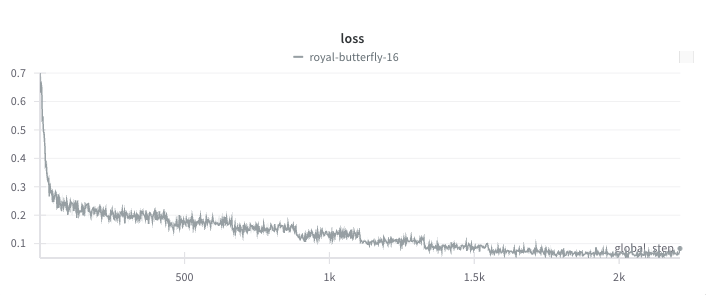

**After all steps** of the fine-tuning fininshes we will find the saved checkpoint under
`./checkpoints/llama3_2_vision_11B/lora/epoch_9` the default in this notebook will be to run a couple of steps so the weights will be located in `./checkpoints/llama3_2_vision_11B/lora/epoch_0`

### Run Generation Recipes
Lets have a look at the fine-tuned results. For that we need one of the samples from the dataset to feed to the model:

In [ ]:
from IPython.display import display

sample = next(iter(reasoning_ds['train']))
sample_query = sample['query']
sample_image = "example_chart.png"
display(sample['image'])
print(f"{sample['query']=}")
sample['image'].save(sample_image)


Next, we can run the generate recipes for the base model:

In [ ]:
! tune run generate_v2.py --config configs/11B_generation_v2.yaml prompt.user.image=example_chart.png

And the fine-tuned moel weights. Make sure to adjust the checkpoint_dir depending on the length of training.

In [ ]:
! tune run generate_v2.py --config configs/11B_generation_v2.yaml checkpointer.checkpoint_dir=./checkpoints/llama3_2_vision_11B/lora/epoch_0 prompt.user.text="$sample_query" prompt.user.image="$sample_image"

We can see that already a couple of steps lets the model get the required format right:

Baseline result:
```
Yes, the value of Favorable in 2015 is 38.
```

Fine-tuned result:
```
Yes, the value of Favorable in 2015 is 38.

Final Answer: 38
```

Fine-tuned result after 10 epochs:
```
The graph shows the trend of Favorable and Unfavorable ratings for China from 2005 to 2015. The green line represents the Favorable ratings, and the orange line represents the Unfavorable ratings. In 2015, the green line is at 38, indicating that the Favorable rating was 38 in 2015.

Final answer: Yes
```

### Run the Evaluation

As a next step we can run an evaluation which will use the test portion of the ChartQA dataset to evaluate our fine-tuned model. Torchtune offers an integration of the [lm-evaluation-harness](https://github.com/EleutherAI/lm-evaluation-harness) package from Eleuther.ai which includes an eval task for ChartQA. We need to slightly modify the default evaluation recipes of Torchtune to comply with the multi-modal interface of the lm_harness.

**Note:** The notebook repo provides the modified recipes but in case you want to create your own modified version you can copy all recipes for local modification with `! tune cp recipes_name recipes_name.py`

The lm_harness is an optional dependency so we need to manually install it (Optional):

In [ ]:
# Ignore the following line because lm-evaluation-harness is installed 
#! pip install git+https://github.com/EleutherAI/lm-evaluation-harness.git@2cfdd0a294214fe156caa1b8a69da17a29c39e63

To start the evaluation we run the modified eleuther_eval.py recipes with a customized configuration. For the sake brevity of this notebook we will overwrite the number of samples with limit=1. If we want to test the whole chartqa dataset, then just use limit=2500. Note that whole dataset takes ~7 hours:

In [ ]:
!tune run eleuther_eval.py --config configs/11B_evaluation.yaml checkpointer.checkpoint_dir='./checkpoints/llama3_2_vision_11B/lora/epoch_0/' limit=1

The output contains the generated chain of though as well as the eval results which will only make sense if we run the evaluation on more samples.
For the complete test set the result should look like this:
```
| Tasks |Version|Filter|n-shot|     Metric      |   |Value |   |Stderr|
|-------|------:|------|------|-----------------|---|-----:|---|-----:|
|chartqa|      0|none  |None  |anywhere_accuracy|↑  |0.7524|±  |0.0086|
|       |       |none  |None  |exact_match      |↑  |0.6168|±  |0.0097|
|       |       |none  |None  |relaxed_accuracy |↑  |0.7520|±  |0.0086|
```
If we compare this to the baseline by running the evaluation on the base weight we see that the finetuning improve the accuracy significantly:
```bash
!tune run eleuther_eval.py --config configs/11B_evaluation.yaml checkpointer.checkpoint_dir='/tmp/Llama-3.2-11B-Vision-Instruct/' limit=2500
```
The baseline results are:
```
| Tasks |Version|Filter|n-shot|     Metric      |   |Value |   |Stderr|
|-------|------:|------|------|-----------------|---|-----:|---|-----:|
|chartqa|      0|none  |None  |anywhere_accuracy|↑  |0.6828|±  |0.0093|
|       |       |none  |None  |exact_match      |↑  |0.0852|±  |0.0056|
|       |       |none  |None  |relaxed_accuracy |↑  |0.3628|±  |0.0096|
```


## [Next Level Challenge][Optional] Fine-tuning the Llama 3.2 90B Vision Instruct Model


Next, we want to really leverage the 192 GB of a single AMD Instinct MI300X and train a 90B parameter model using a single GPU. To fit this big model we will leverage QLoRA which aditionally to adding LoRA adapter weights to the transformer layers will also quantize the original model weights to save space. The freed memory due to the quantization can be utilized to increase the batch size, thus processing more examplesper step.

### Download Model and Run the Fine-Tuning

We already downloaded the model weights of the Llama 3.2 90B Vision Instruct while creating the reasoning dataset so we only need to adjust the path to the weight folder. Alternatively we can let Torchtune place the files at the desired location without re-downloading as it can access the cached weights.


In [ ]:
! tune download meta-llama/Llama-3.2-90B-Vision-Instruct --output-dir /tmp/Llama-3.2-90B-Vision-Instruct --ignore-patterns "original/consolidated*.pth"

Subsequently, we can start the finetuning using the lora_fintune_single_device recipes with a customized qlora configuration. There is overwrite parameters in the end of the commands below to allow user finish it in 10 mins. 

In [ ]:
# Remove the overwrite parameters in the end (max_steps_per_epoch=1 epochs=1) to run the full fine-tuning
# Because of DRAM limitation from 1-gpu setup, we will skip this finetune:
# ! tune run lora_finetune_single_device --config configs/llama3_2_vision_90B_qlora.yaml max_steps_per_epoch=20 epochs=1

After fine-tuning we can run generate for base weights:

In [ ]:
! tune run generate_v2.py --config configs/90B_generation_v2.yaml  prompt.user.text="$sample_query" prompt.user.image="$sample_image"

And fine-tuned weights by downloading pre-uploaded Llama3.2 vision 90B lora checkpoint from epoch0 :

In [ ]:
! tune download mirr0rman/llama3_2_vision_90B_lora_epoch0 --output-dir /tmp/mirr0rman_llama3_2_vision_90B_lora_epoch0
! tune run generate_v2.py --config configs/90B_generation_v2.yaml checkpointer.checkpoint_dir=/tmp/mirr0rman_llama3_2_vision_90B_lora_epoch0 prompt.user.text="$sample_query" prompt.user.image="$sample_image"

Finally, we can run the evaluation on the 90B parameter model using the 11B configuration with some minor overwrites:

In [ ]:
!tune run eleuther_eval.py --config configs/90B_evaluation.yaml \
    checkpointer.checkpoint_dir=/tmp/mirr0rman_llama3_2_vision_90B_lora_epoch0 \
    limit=1

As before the evaluation only makes sense if we run the model on a higher number of sampels.
For the whole test split we achieve the following results:

Fine-tuned results:
```
| Tasks |Version|Filter|n-shot|     Metric      |   |Value |   |Stderr|
|-------|------:|------|------|-----------------|---|-----:|---|-----:|
|chartqa|      0|none  |None  |anywhere_accuracy|↑  |0.8328|±  |0.0075|
|       |       |none  |None  |exact_match      |↑  |0.7592|±  |0.0086|
|       |       |none  |None  |relaxed_accuracy |↑  |0.8320|±  |0.0075|
```

Baseline results:
```
| Tasks |Version|Filter|n-shot|     Metric      |   |Value |   |Stderr|
|-------|------:|------|------|-----------------|---|-----:|---|-----:|
|chartqa|      0|none  |None  |anywhere_accuracy|↑  |0.7172|±  |0.0090|
|       |       |none  |None  |exact_match      |↑  |0.2596|±  |0.0088|
|       |       |none  |None  |relaxed_accuracy |↑  |0.3956|±  |0.0098|
```